<a href="https://colab.research.google.com/github/nastjamakh/projects/blob/hollywood-age-gap/04-hollywood-age-gap/notebooks/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

## Color Palette

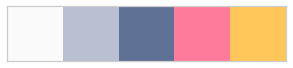

In [3]:
COLOR_BACKGROUND = '#fafafa'
ACCENT_COLORS = ['#FF7B9C', '#FFC759']
MUTED_COLORS = ['#BABFD1', '#607196']
COLORS = [*MUTED_COLORS, *ACCENT_COLORS]
COLOR_PALETTE = sns.color_palette(COLORS, as_cmap=True)
sns.palplot([COLOR_BACKGROUND] + COLORS)

In [4]:
# set background color
plt.rcParams['axes.facecolor']= COLOR_BACKGROUND
plt.rcParams['savefig.facecolor']= COLOR_BACKGROUND

In [5]:
def random_color(accent=False):
    c = ACCENT_COLORS if accent else MUTED_COLORS
    return np.random.choice(c)

random_color()

'#607196'

## Load data

In [65]:
URL_MOVIE_DESCRIPTION = 'https://datasets.imdbws.com/title.basics.tsv.gz'
URL_MOVIE_RATINGS = 'https://datasets.imdbws.com/title.ratings.tsv.gz'
URL_ACTORS = 'https://datasets.imdbws.com/title.principals.tsv.gz'
URL_ACTOR_NAMES = 'https://datasets.imdbws.com/name.basics.tsv.gz'

In [23]:
df_movies = pd.read_csv(URL_MOVIE_DESCRIPTION, sep='\t')
df_ratings = pd.read_csv(URL_MOVIE_RATINGS, sep='\t')
#df_actors = pd.read_csv(URL_ACTORS, sep='\t')
#df_actor_names = pd.read_csv(URL_ACTOR_NAMES, sep='\t')

df = df_movies.merge(df_ratings, on='tconst', how='left')
del df_movies, df_ratings

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1846.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.0,239.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1615.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.0,155.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2437.0


In [24]:
# use np.nan instead of string fill value
df = df.replace('\\N',np.NaN)

# Filter out non-movies and porn movies
df = df.query('(titleType == "movie") and (isAdult ==0)')

# preprocess columns
df = df.drop(['titleType', 'isAdult', 'endYear'], axis=1)
df.columns = ['movie_id', 'primary_title', 'original_title', 'release_year', 'duration', 'genres',
             'rating', 'num_votes']

df.head(3)

,movie_id,primary_title,original_title,release_year,duration,genres,rating,num_votes
498,tt0000502,Bohemios,Bohemios,1905,100,NaN,4.5,14.0
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.1,744.0
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.2,16.0


In [25]:
# preprocess year
df = df[df.release_year.notnull()]
df.release_year = df.release_year.astype(int)
df = df.query('release_year >= 1960')
print(f'Dataset contains {df.shape[0]:,} movies released since 1960')

# remove movies that were not released yet
df = df[df.release_year < 2022]

Dataset contains 418,847 movies released since 1960


In [26]:
# extract romance genre
print(f'{round(df.genres.isnull().sum() / df.shape[0] * 100,2)}% have no genre information.')
df = df[df.genres.notnull()]
df['is_romance'] = df.genres.str.lower().str.contains('romance')

pct_romance = df.is_romance.sum() / df.shape[0] * 100
print(f'{round(pct_romance,2)}% of movies have romantic plot.')

10.34% have no genre information.
8.47% of movies have romantic plot.


Text(0.5, 1.0, 'How Many Movies Were Released This Year?')

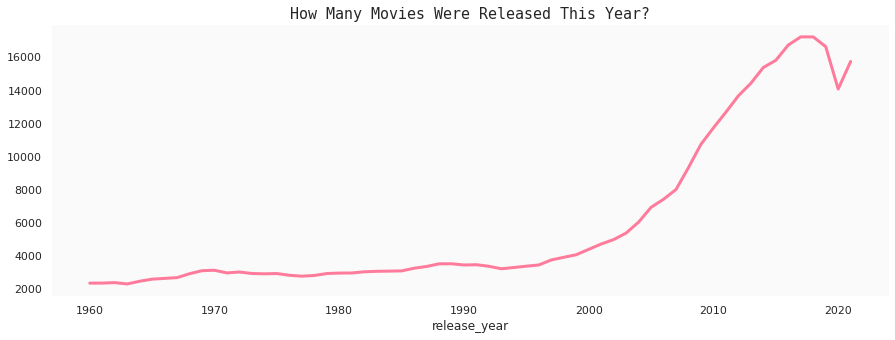

In [27]:
plt.figure(figsize=(15,5))
df.groupby('release_year').count().primary_title.plot(color=random_color(True), lw=3)
sns.despine(bottom = True, left = True)
plt.title('How Many Movies Were Released This Year?', fontsize=15, fontfamily='monospace')

Text(0.5, 1.0, 'Proportion of Romantic Movies By Year')

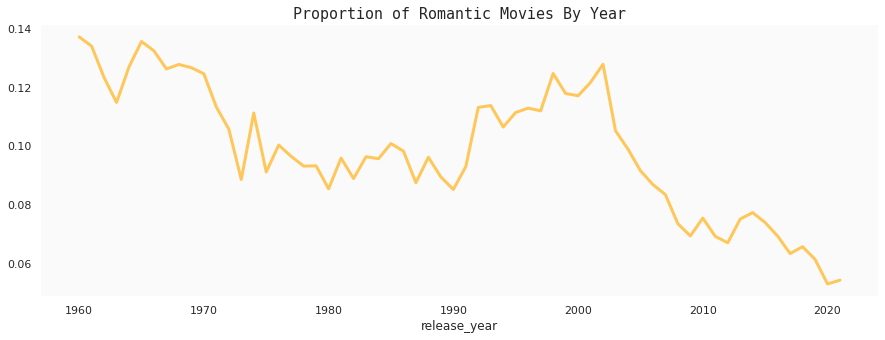

In [28]:
plt.figure(figsize=(15,5))
df.groupby('release_year').apply(lambda year: year.is_romance.sum() / year.shape[0])\
        .plot(color=random_color(True), lw=3)
sns.despine(bottom = True, left = True)
plt.title('Proportion of Romantic Movies By Year', fontsize=15, fontfamily='monospace')

## Add Ratings

In [29]:
df_romances = df.query('is_romance')
df_romances.head(3)

,movie_id,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance
15487,tt0015724,Dama de noche,Dama de noche,1993,102,"Drama,Mystery,Romance",6.2,25.0,True
34805,tt0035423,Kate & Leopold,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,82503.0,True
46189,tt0047027,La gitana y el charro,La gitana y el charro,1964,87,"Comedy,Musical,Romance",4.8,15.0,True


In [30]:
# remove when duration over 3 hours 
# preprocess duration
df_romances = df_romances[df_romances.duration.notnull()]
df_romances.duration = df_romances.duration.astype(int)
df_romances = df_romances[df_romances.duration <= 180]

Text(0.5, 1.0, 'How Long are the Romantic Movies?')

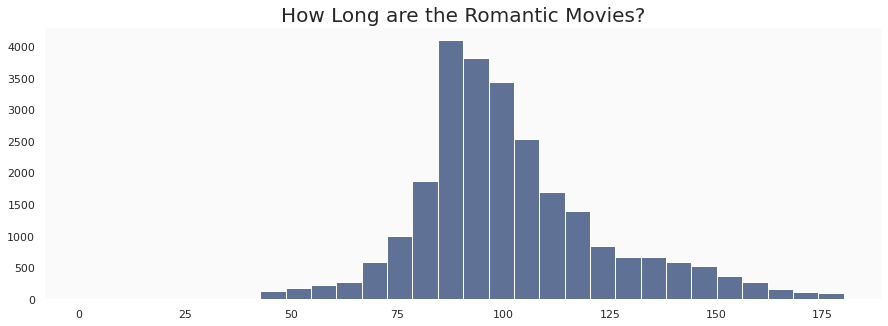

In [31]:
plt.figure(figsize=(15,5))
df_romances.duration.hist(bins=30, color=random_color())
sns.despine(bottom = True, left = True)
plt.grid(False)
plt.title('How Long are the Romantic Movies?', fontsize=20)

Text(0.5, 1.0, 'How Romantic Movies Are Rated?')

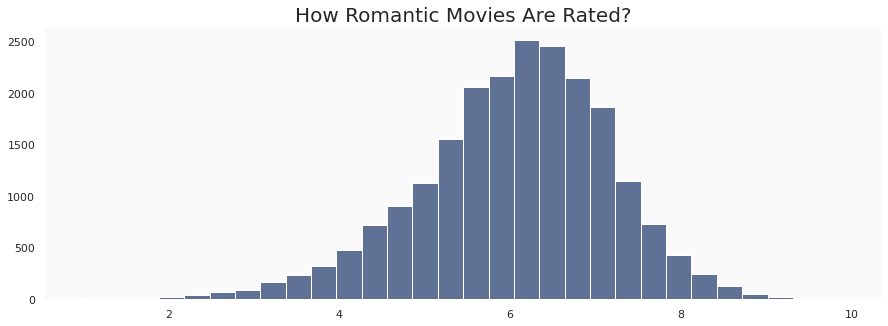

In [32]:
plt.figure(figsize=(15,5))
df_romances.rating.hist(bins=30, color=random_color())
sns.despine(bottom = True, left = True)
plt.grid(False)
plt.title('How Romantic Movies Are Rated?', fontsize=20)

In [33]:
num_no_votes = df_romances[df_romances.num_votes.isnull()].shape[0] / df.shape[0] * 100
print(f'{round(num_no_votes,2)}% of movies have no votes on IMDB.')

df_romances = df_romances[df.num_votes.notnull()]
df_romances.shape[0]

1.05% of movies have no votes on IMDB.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


21736

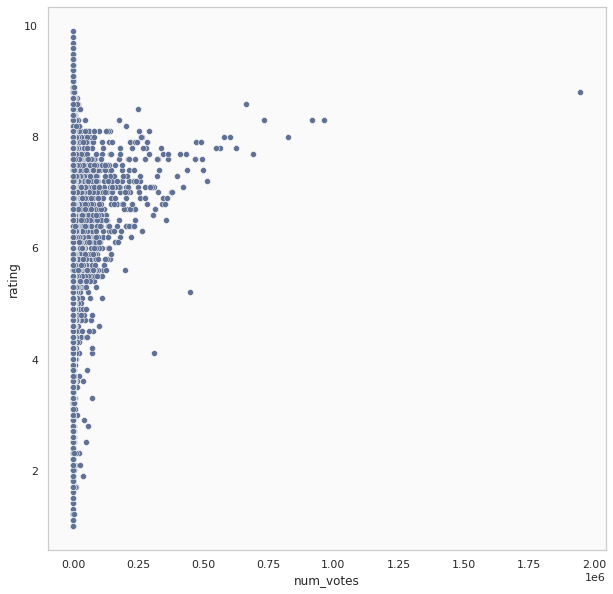

In [34]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_romances, x='num_votes', y='rating', color=random_color())

In [35]:
pct_foreign = df_romances[df_romances.primary_title != df_romances.original_title].shape[0] / df_romances.shape[0]
df_romances = df_romances.query('primary_title == original_title')

In [117]:
TOP_YEAR = 20
data = df_romances.groupby('release_year')\
    .apply(lambda y: y.sort_values(by='num_votes', ascending=False).iloc[:TOP_YEAR])\
    .set_index('movie_id').sort_values(by='release_year', ascending=False)
data.head()

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance
movie_id,,,,,,,,
tt8231668,Good on Paper,Good on Paper,2021,92,"Comedy,Romance",5.6,10672.0,True
tt9766332,Atrangi Re,Atrangi Re,2021,138,"Comedy,Drama,Romance",6.7,18270.0,True
tt10293406,The Power of the Dog,The Power of the Dog,2021,126,"Drama,Romance,Western",7.0,72069.0,True
tt8847712,The French Dispatch,The French Dispatch,2021,107,"Comedy,Drama,Romance",7.3,63765.0,True
tt10752004,Love Hard,Love Hard,2021,104,"Comedy,Romance",6.3,44818.0,True


## Add Actors and Age

In [ ]:
#df_actors = pd.read_csv(URL_ACTORS, sep='\t')
#df_actors.head()

In [66]:
#df_actor_names = pd.read_csv(URL_ACTOR_NAMES, sep='\t')
#df_actor_names.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0072308,tt0050419,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0117057,tt0037382,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0072562,tt0080455,tt0077975,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0083922,tt0060827"


In [118]:
romantic_movies = data.index.tolist()
actors = df_actors.query('tconst in @romantic_movies')
assert actors.tconst.nunique() == len(romantic_movies)

In [119]:
def get_main_couple(movie):
  if ('actress' not in movie.category.unique()) or ('actor' not in movie.category.unique()):
    return None
  actress = movie.query('category == "actress"').nconst.iloc[0]
  actor = movie.query('category == "actor"').nconst.iloc[0]
  return {'actress': actress, 'actor': actor}

In [120]:
actors = actors.groupby('tconst').apply(lambda movie: get_main_couple(movie))
lead_actress = actors.apply(lambda l: None if not l else l['actress'])
lead_actor = actors.apply(lambda l: None if not l else l['actor'])

data['nconst_actress'] = lead_actress
data['nconst_actor'] = lead_actor

In [125]:
data = data\
  .merge(df_actor_names[['nconst', 'primaryName', 'birthYear']], left_on='nconst_actor', right_on='nconst', how='left')\
  .rename(columns={'primaryName': 'actor', 'birthYear': 'actor_birth_year'})\
  .drop(['nconst'], axis=1)\
  .merge(df_actor_names[['nconst', 'primaryName', 'birthYear']], left_on='nconst_actress', right_on='nconst', how='left')\
  .rename(columns={'primaryName': 'actress', 'birthYear': 'actress_birth_year'})\
  .drop(['nconst_actress'], axis=1)

data.head(3)

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance,nconst_actor,actor,actor_birth_year,nconst,actress,actress_birth_year
0,Good on Paper,Good on Paper,2021,92,"Comedy,Romance",5.6,10672.0,True,nm2166469,Christopher Nicholas Smith,\N,nm2955597,Iliza Shlesinger,1983
1,Atrangi Re,Atrangi Re,2021,138,"Comedy,Drama,Romance",6.7,18270.0,True,nm1333687,Dhanush,1983,nm9071083,Sara Ali Khan,\N
2,The Power of the Dog,The Power of the Dog,2021,126,"Drama,Romance,Western",7.0,72069.0,True,nm1212722,Benedict Cumberbatch,1976,nm0000379,Kirsten Dunst,1982


In [144]:
# preprocess years
data.actor_birth_year = data.actor_birth_year.replace('\\N', np.nan).astype(np.float).astype("Int32")
data.actress_birth_year = data.actress_birth_year.replace('\\N', np.nan).astype(np.float).astype("Int32")

In [322]:
data['actress_age'] = data.release_year - data.actress_birth_year
data['actor_age'] = data.release_year - data.actor_birth_year
data['age_gap'] = data.actress_birth_year - data.actor_birth_year

data.head(3)

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance,nconst_actor,actor,actor_birth_year,nconst_actress,actress,actress_birth_year,actress_age,actor_age,age_gap,actor_age_bin,actress_age_bin
0,Reminiscence,Reminiscence,2021,116,"Mystery,Romance,Sci-Fi",5.9,44138.0,True,nm0413168,Hugh Jackman,1968,nm0272581,Rebecca Ferguson,1983,38,53,15,"(50.0, 55.0]","(35.0, 40.0]"
1,Malcolm & Marie,Malcolm & Marie,2021,106,"Drama,Romance",6.7,33882.0,True,nm0913475,John David Washington,1984,nm3918035,Zendaya,1996,25,37,12,"(35.0, 40.0]","(20.0, 25.0]"
2,Locked Down,Locked Down,2021,118,"Comedy,Crime,Romance",5.2,10823.0,True,nm0252230,Chiwetel Ejiofor,1977,nm0004266,Anne Hathaway,1982,39,44,5,"(40.0, 45.0]","(35.0, 40.0]"


In [244]:
#data.to_csv('sample_data/top_romantic_movies_by_year.csv')

In [353]:
data = pd.read_csv('top_romantic_movies_by_year.csv', sep=';')\
  .drop('Unnamed: 0', axis=1)

data['actress_age'] = data.release_year - data.actress_birth_year
data['actor_age'] = data.release_year - data.actor_birth_year
data['age_gap'] = data.actress_birth_year - data.actor_birth_year

data = data.query('(actor_age > 14) & (actress_age > 14) & (actress_age < 75)')

data.head(5)

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance,nconst_actor,actor,actor_birth_year,nconst_actress,actress,actress_birth_year,actress_age,actor_age,age_gap,actor_age_bin,actress_age_bin
0,Reminiscence,Reminiscence,2021,116,"Mystery,Romance,Sci-Fi",5.9,44138.0,True,nm0413168,Hugh Jackman,1968,nm0272581,Rebecca Ferguson,1983,38,53,15,"(50.0, 55.0]","(35.0, 40.0]"
1,Malcolm & Marie,Malcolm & Marie,2021,106,"Drama,Romance",6.7,33882.0,True,nm0913475,John David Washington,1984,nm3918035,Zendaya,1996,25,37,12,"(35.0, 40.0]","(20.0, 25.0]"
2,Locked Down,Locked Down,2021,118,"Comedy,Crime,Romance",5.2,10823.0,True,nm0252230,Chiwetel Ejiofor,1977,nm0004266,Anne Hathaway,1982,39,44,5,"(40.0, 45.0]","(35.0, 40.0]"
3,In the Heights,In the Heights,2021,143,"Drama,Musical,Romance",7.3,40806.0,True,nm6588867,Anthony Ramos,1991,nm6051155,Leslie Grace,1995,26,30,4,"(25.0, 30.0]","(25.0, 30.0]"
4,The Map of Tiny Perfect Things,The Map of Tiny Perfect Things,2021,98,"Comedy,Fantasy,Romance",6.8,18978.0,True,nm6563873,Kyle Allen,1994,nm1105980,Kathryn Newton,1997,24,27,3,"(25.0, 30.0]","(20.0, 25.0]"


## **Analysis**

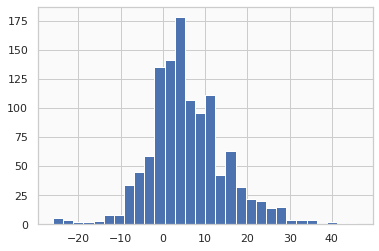

In [354]:
data.age_gap.hist(bins=30)

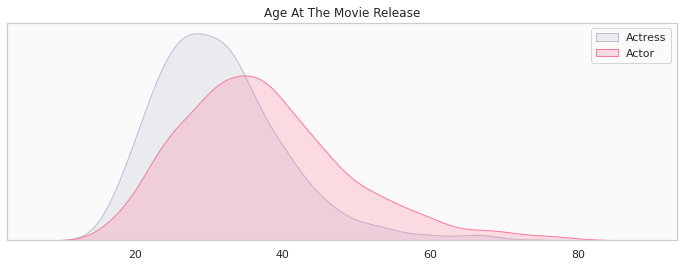

In [383]:
plt.figure(figsize=(12,4))
sns.kdeplot(data.actress_age, fill=True, color=random_color(), label='Actress')
sns.kdeplot(data.actor_age, fill=True, color=random_color(True), label='Actor')

plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.grid(False)
plt.title('Age At The Movie Release')
plt.legend()

Text(0.5, 1.0, 'Actor Age by Release Date')

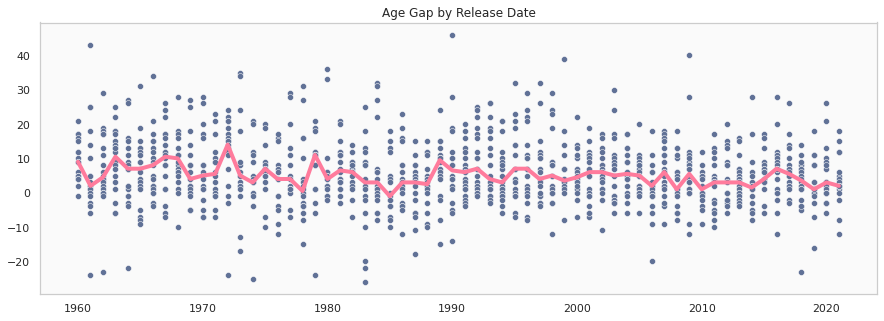

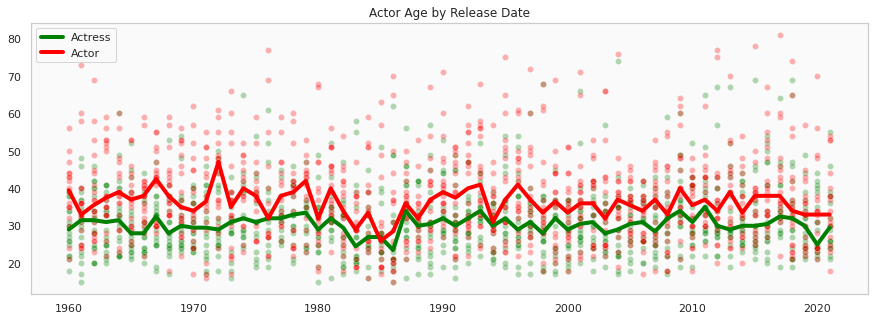

In [402]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=data, x='release_year', y='age_gap', ax=ax, color=random_color(False))
data.groupby('release_year').age_gap.median().plot(ax=ax, color=random_color(True), lw=4)

plt.grid(False)
plt.xlabel('')
plt.ylabel('')
plt.title('Age Gap by Release Date')

# actor age
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=data, x='release_year', y='actress_age',
                ax=ax, color='green', alpha=0.3)
sns.scatterplot(data=data, x='release_year', y='actor_age',
                ax=ax, color='red', alpha=0.3)
data.groupby('release_year').actress_age.median().plot(ax=ax, color='green',
                                                       lw=4, label='Actress')
data.groupby('release_year').actor_age.median().plot(ax=ax, color='red',
                                                     lw=4, label='Actor')

plt.grid(False)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.title('Actor Age by Release Date')

In [403]:
vals = np.arange(7,85)
age_bounds = pd.DataFrame({'age': vals}, index=vals)

In [404]:
age_bounds['lower_bound'] = (age_bounds.age-7)*2
age_bounds['upper_bound'] = age_bounds.age/2 + 7
age_bounds.head(3)

,age,lower_bound,upper_bound
7,7,0,10.5
8,8,2,11.0
9,9,4,11.5


Text(0.5, 1.0, 'Who is Older?')

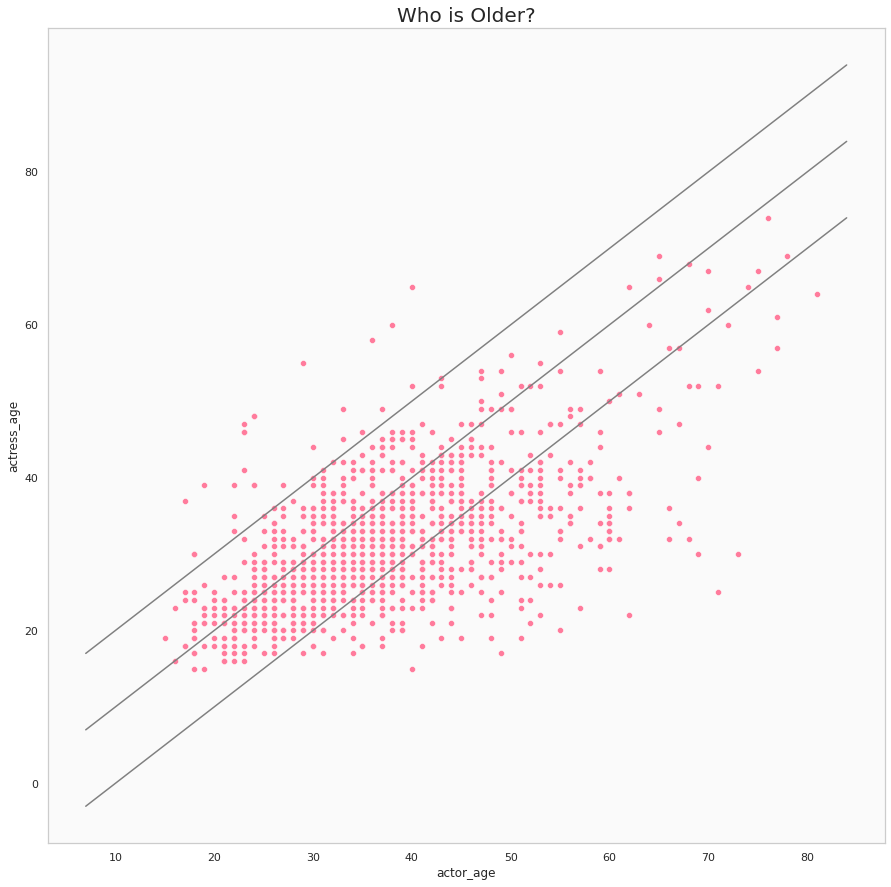

In [421]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=data.query('actress_age < 75'), x='actor_age', y='actress_age', color=random_color(True))

age_bounds.age.plot(color='grey')
(age_bounds.age+10).plot(color='grey')
(age_bounds.age-10).plot(color='grey')
plt.title('Who is Older?', fontsize=20)

In [406]:
data.actor_age = data.actor_age.astype(float)
data.actress_age = data.actress_age.astype(float)
data.age_gap = data.age_gap.astype(float)

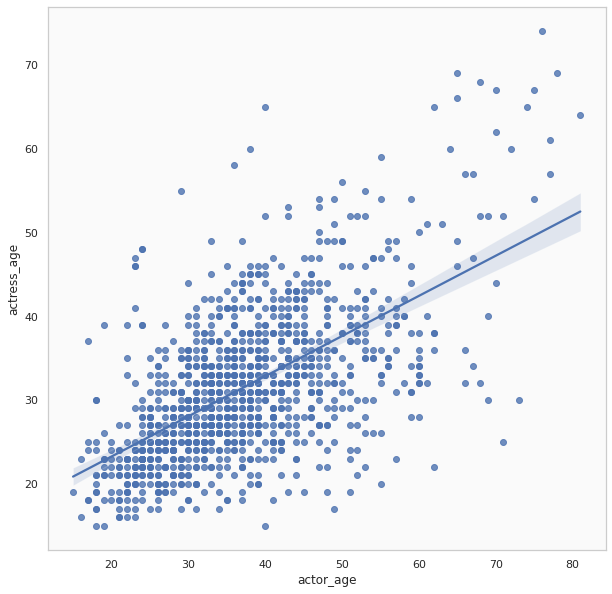

In [407]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.regplot(x='actor_age', y='actress_age', data=data, ax=ax)

In [408]:
actor_age_bins = pd.cut(data.actor_age,bins=[0,14, 20,25,30,35,40,45,50,55,60,65,81])
actress_age_bins = pd.cut(data.actress_age,bins=[0,14,20,25,30,35,40,45,50,55,60,65,81])
data['actor_age_bin'] = actor_age_bins
data['actress_age_bin'] = actress_age_bins

Text(0.5, 0.98, 'How Old is the Romantic Partner?')

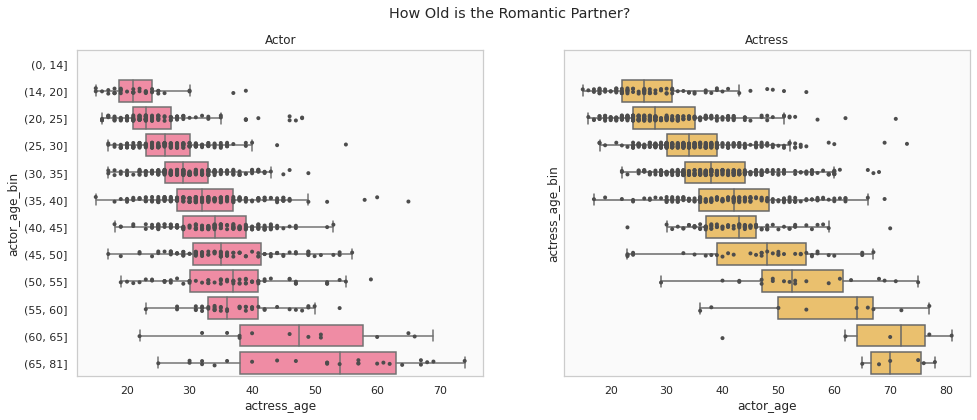

In [409]:
fig, axs = plt.subplots(1,2, figsize=(16,6), sharey=True)

sns.boxplot(data=data, y='actor_age_bin', x='actress_age', showfliers=False, color=random_color(True), ax=axs[0])
sns.stripplot(x="actress_age", y="actor_age_bin", data=data.dropna(),
              size=4, color=".3", linewidth=0, ax=axs[0])
axs[0].set_title('Actor')

sns.boxplot(data=data, y='actress_age_bin', x='actor_age', showfliers=False, color=random_color(True), ax=axs[1])
sns.stripplot(x="actor_age", y="actress_age_bin", data=data.dropna(),
              size=4, color=".3", linewidth=0, ax=axs[1])
axs[1].set_title('Actress')

fig.suptitle('How Old is the Romantic Partner?')

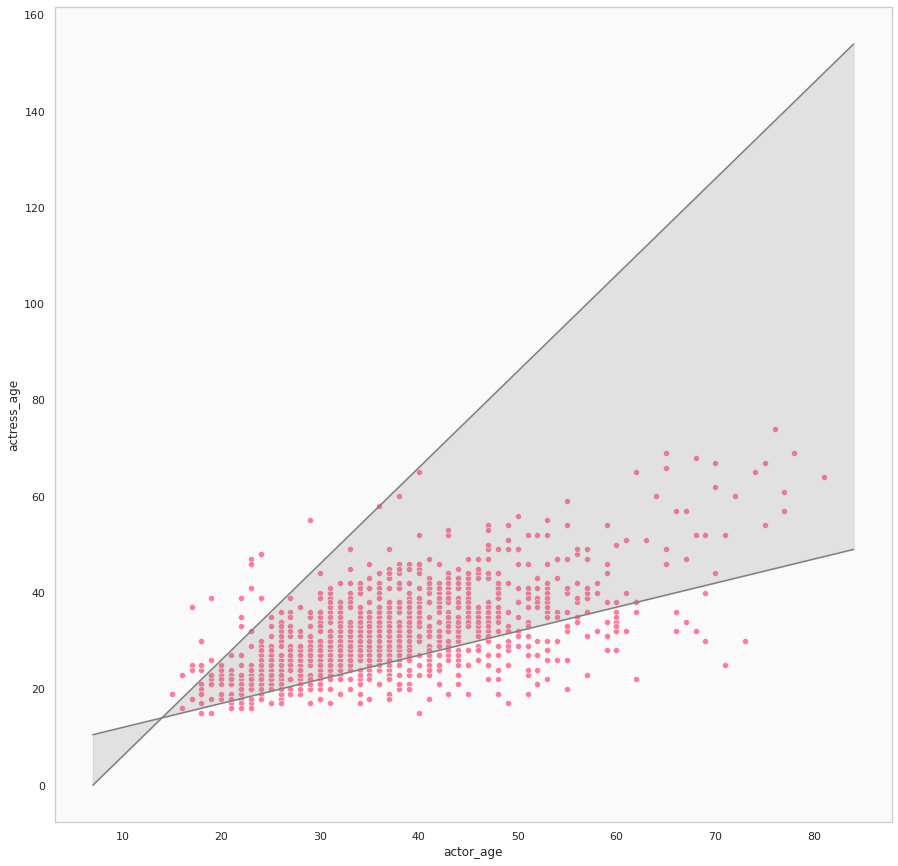

In [410]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=data, x='actor_age', y='actress_age', color=random_color(True))

#age_bounds.age.plot()
age_bounds.lower_bound.plot(color='grey')
age_bounds.upper_bound.plot(color='grey')

plt.fill_between(age_bounds.age, age_bounds.lower_bound, age_bounds.upper_bound,
                 alpha=0.2, color='grey')

In [411]:
def is_too_old(age1, age2):
  return age1 > (age2-7)*2

In [413]:
data['is_man_too_old'] = data.apply(lambda row: is_too_old(row.actor_age, row.actress_age), axis=1)
data['is_woman_too_old'] = data.apply(lambda row: is_too_old(row.actress_age, row.actor_age), axis=1)

In [420]:
data[data.is_man_too_old].sort_values(by='age_gap', ascending=False)

,primary_title,original_title,release_year,duration,genres,rating,num_votes,is_romance,nconst_actor,actor,actor_birth_year,nconst_actress,actress,actress_birth_year,actress_age,actor_age,age_gap,actor_age_bin,actress_age_bin,is_man_too_old,is_woman_too_old
601,Ju Dou,Ju Dou,1990,95,"Drama,Romance",7.7,8190.0,True,nm0508536,Wei Li,1919,nm0000084,Gong Li,1965,25.0,71.0,46.0,"(65, 81]","(20, 25]",True,False
1133,Fanny,Fanny,1961,134,"Drama,Romance",6.9,2194.0,True,nm0002001,Maurice Chevalier,1888,nm0001989,Leslie Caron,1931,30.0,73.0,43.0,"(65, 81]","(25, 30]",True,False
229,Whatever Works,Whatever Works,2009,93,"Comedy,Romance",7.1,73284.0,True,nm0202970,Larry David,1947,nm0939697,Evan Rachel Wood,1987,22.0,62.0,40.0,"(60, 65]","(20, 25]",True,False
426,Entrapment,Entrapment,1999,113,"Action,Crime,Romance",6.3,113110.0,True,nm0000125,Sean Connery,1930,nm0001876,Catherine Zeta-Jones,1969,30.0,69.0,39.0,"(65, 81]","(25, 30]",True,False
784,Xanadu,Xanadu,1980,96,"Fantasy,Musical,Romance",5.3,13028.0,True,nm0000037,Gene Kelly,1912,nm0000556,Olivia Newton-John,1948,32.0,68.0,36.0,"(65, 81]","(30, 35]",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,Can't Buy Me Love,Can't Buy Me Love,1987,94,"Comedy,Drama,Romance",6.8,35857.0,True,nm0001131,Patrick Dempsey,1966,nm0000584,Amanda Peterson,1971,16.0,21.0,5.0,"(20, 25]","(14, 20]",True,False
696,Legend,Legend,1985,94,"Adventure,Fantasy,Romance",6.4,63685.0,True,nm0000129,Tom Cruise,1962,nm0000214,Mia Sara,1967,18.0,23.0,5.0,"(20, 25]","(14, 20]",True,False
791,The Blue Lagoon,The Blue Lagoon,1980,104,"Adventure,Drama,Romance",5.8,67615.0,True,nm0000803,Christopher Atkins,1961,nm0000222,Brooke Shields,1965,15.0,19.0,4.0,"(14, 20]","(14, 20]",True,False
433,The Virgin Suicides,The Virgin Suicides,1999,97,"Drama,Romance",7.2,150750.0,True,nm0001326,Josh Hartnett,1978,nm0000379,Kirsten Dunst,1982,17.0,21.0,4.0,"(20, 25]","(14, 20]",True,False


In [ ]:
age_gap_bins = [-30, ]

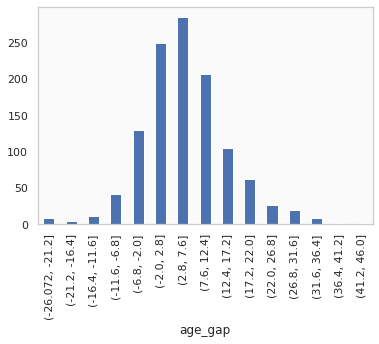

In [426]:
data.groupby(pd.cut(data.age_gap, 15)).count().primary_title.plot.bar()